In [1]:
import dask_geopandas
import geopandas as gpd
import pandas as pd
import dask.dataframe as dd
import numpy as np
from dask.distributed import Client, LocalCluster
import pygeos

from utils.dask_geopandas import dask_dissolve

/opt/conda/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
folder = "../../urbangrammar_samba/sp_sig_concept/barcelona/"

In [3]:
client = Client(LocalCluster(n_workers=16))
client

Client Scheduler: tcp://127.0.0.1:44819 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 134.91 GB


In [3]:
tess = gpd.read_parquet(folder + "tess.pq", columns=['tessellation']).rename_geometry("geometry")
# clusters = pd.read_parquet(folder + "FINAL_cluster_19_labels.pq")
clusters = pd.read_csv(folder + "FINAL_cluster_labels.csv")

In [4]:
tess['cluster'] = clusters.clusters.values

In [6]:
%%time
ddf = dask_geopandas.from_geopandas(tess, npartitions=64)
final = dask_dissolve(ddf, by='cluster').compute()

CPU times: user 2min 59s, sys: 13.6 s, total: 3min 12s
Wall time: 13min 44s


In [31]:
%%time
ddf = dask_geopandas.from_geopandas(tess.sort_values('cluster').reset_index(drop=True), npartitions=64)
final = dask_dissolve(ddf, by='cluster').compute()

CPU times: user 7min 13s, sys: 38.3 s, total: 7min 52s
Wall time: 34min 11s


<AxesSubplot:>

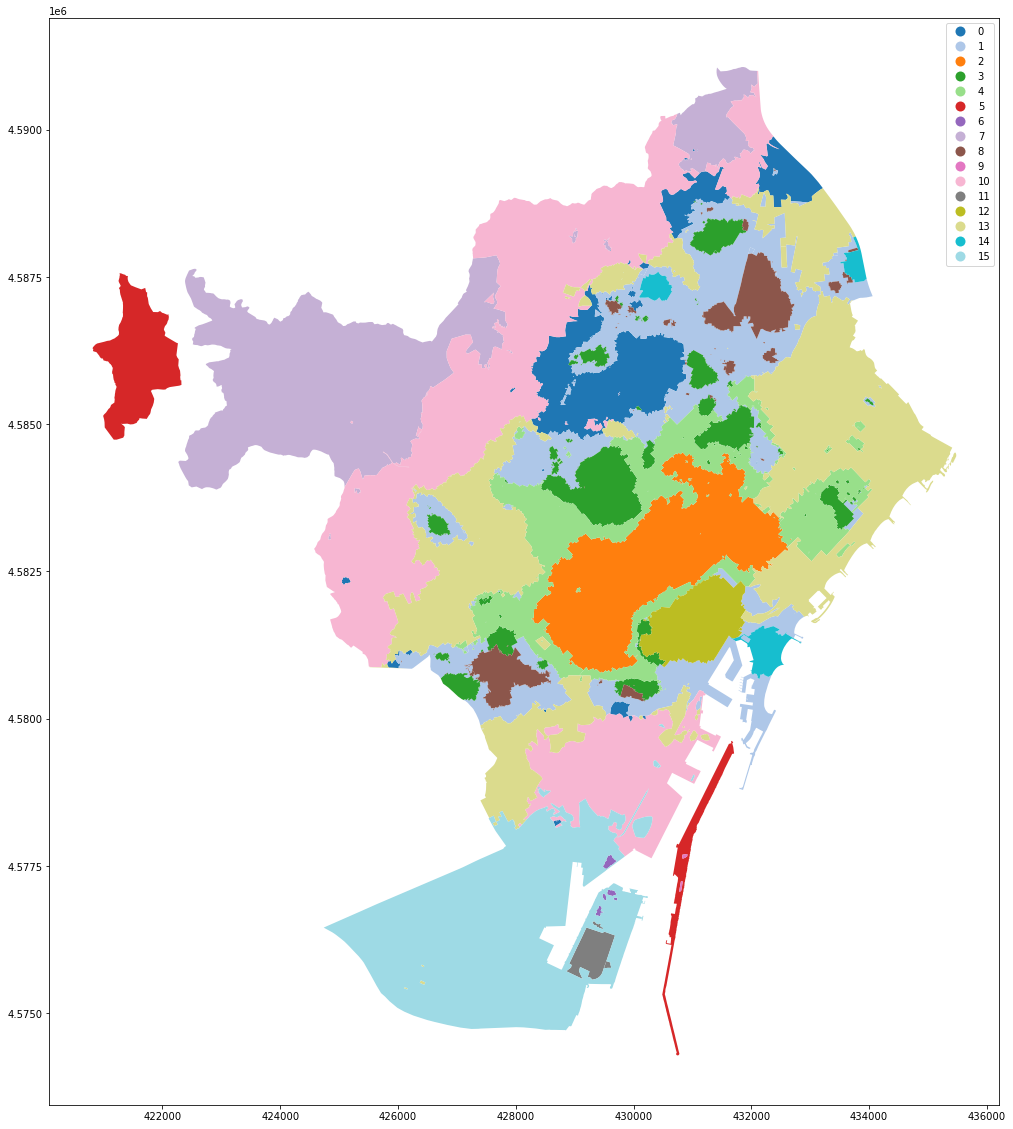

In [33]:
final.plot('cluster', categorical=True, figsize=(20, 20), cmap='tab20', legend=True)

In [103]:
from time import time

In [ ]:
s = time()
dis = tess.dissolve('cluster')
f = time() - s

In [105]:
f

6849.834819078445

In [34]:
tess.cluster.value_counts()

1     13468
3     13330
4      9397
2      8619
8      7284
13     7169
0      6855
12     4334
10     4214
7      3789
14     2083
15     1232
11      412
6       161
5        26
9         2
Name: cluster, dtype: int64

In [5]:
tess.total_bounds

array([ 420812.5398, 4574282.45  ,  435480.359 , 4591066.026 ])

In [41]:
sample = tess.cx[426000:428000, 4581000:4582000]

In [42]:
sample.shape

(2285, 2)

In [34]:
%time r = sample.unary_union

CPU times: user 11.2 s, sys: 4.41 ms, total: 11.2 s
Wall time: 11.2 s


In [30]:
%time r = gpd.GeoSeries([sample.iloc[top:top+10].unary_union for top in range(0, 648, 10)]).unary_union

CPU times: user 4.88 s, sys: 359 µs, total: 4.88 s
Wall time: 4.87 s


In [31]:
%time r = gpd.GeoSeries([sample.iloc[top:top+50].unary_union for top in range(0, 648, 50)]).unary_union

CPU times: user 5.91 s, sys: 324 µs, total: 5.92 s
Wall time: 5.91 s


In [32]:
%time r = gpd.GeoSeries([sample.iloc[top:top+100].unary_union for top in range(0, 648, 100)]).unary_union

CPU times: user 5.21 s, sys: 7.76 ms, total: 5.22 s
Wall time: 5.22 s


In [33]:
%time r = gpd.GeoSeries([sample.iloc[top:top+200].unary_union for top in range(0, 648, 200)]).unary_union

CPU times: user 2.03 s, sys: 39 µs, total: 2.03 s
Wall time: 2.03 s


In [37]:
from time import time

In [47]:
times = pd.DataFrame(columns=['time'])

CPU times: user 2min 7s, sys: 20.1 ms, total: 2min 7s
Wall time: 2min 7s


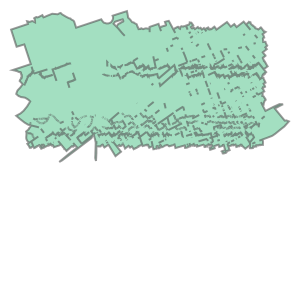

In [53]:
%time sample.unary_union

In [56]:
for split in [2, 5, 10, 25, 50, 100, 150, 200, 300, 700, 1400]:
    s = time()
    r = gpd.GeoSeries([sample.iloc[top:top+split].unary_union for top in range(0, sample.shape[0], split)]).unary_union
    times.loc[split] = time() - s

<AxesSubplot:xlabel='split size', ylabel='time'>

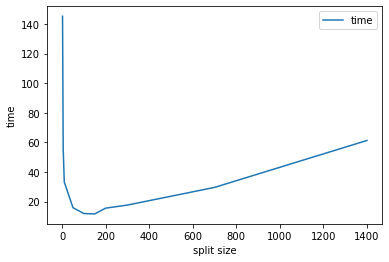

In [57]:
times.plot(xlabel="split size", ylabel='time')

In [59]:
sample.to_parquet('sample.pq')

<ipython-input-59-9ee2523e3c1a>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  sample.to_parquet('sample.pq')


In [60]:
from time import time

sample = gpd.read_parquet('sample.pq')

geoms = sample.geometry.values.data

In [62]:
times = pd.DataFrame(columns=['time'])

In [65]:
size = geoms.shape[0]

for split in [2, 5, 10, 25, 50, 100, 150, 200, 350, 500, 1000, 1500]:
    s = time()
    unoined = pygeos.union_all(
        [pygeos.union_all(geoms[edge : edge + split]) for edge in range(0, size, split)]
    )
    times.loc[split] = time() - s

<AxesSubplot:xlabel='split size', ylabel='time'>

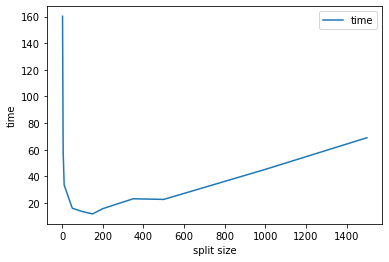

In [66]:
times.plot(xlabel="split size", ylabel='time')

In [67]:
times

,time
2,160.202655
5,58.607774
10,33.442504
25,26.888456
50,16.020998
100,13.533087
150,11.767659
200,15.715614
350,23.145546
500,22.656922


In [68]:
%time r= pygeos.union_all(geoms)

CPU times: user 2min 11s, sys: 3.99 ms, total: 2min 11s
Wall time: 2min 11s


In [69]:
pygeos.__version__

'0.8'

In [70]:
gpd.show_versions()


SYSTEM INFO
-----------
python     : 3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05)  [GCC 7.5.0]
executable : /opt/conda/bin/python
machine    : Linux-4.15.0-132-generic-x86_64-with-glibc2.10

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : 3.8.1
GEOS lib   : /opt/conda/lib/libgeos_c.so
GDAL       : 3.1.4
GDAL data dir: /opt/conda/share/gdal
PROJ       : 7.1.1
PROJ data dir: /opt/conda/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.8.1
pandas     : 1.1.4
fiona      : 1.8.18
numpy      : 1.19.4
shapely    : 1.7.1
rtree      : 0.9.4
pyproj     : 2.6.1.post1
matplotlib : 3.3.3
mapclassify: 2.3.0
geopy      : 2.0.0
psycopg2   : 2.8.6 (dt dec pq3 ext lo64)
geoalchemy2: 0.8.4
pyarrow    : 2.0.0
